
With the exception of people who deploy to production on a Friday evening because YOLO, we all agree that model validation matters: measuring the performance of an ML model (and hence its generalisation power) allows us to assess the robustness, optimise parameters and estimate performance on unseen data. If there is a good reason to believe the underlying data generating process is stationary (no concept drift), you are usually fine with training-validation-test split (overfitting to validation set notwithstanding). It becomes slightly more complicated if the temporal dimension matters: in this episode we will walk through different manners of assessing performance of time series models without breaking the arrow of time.


* [Naive Random split](#section-one)
* [KFold](#section-two)
* [Time Series Split (Walk forward)](#section-three)
* [Group Time Series](#section-four)
* [Purged Group KFold](#section-five)
* [Combinatorial Purged Group KFold](#section-six)


In [75]:
import time
import os
from IPython.display import Image
import pandas as pd
import numpy as np
import lightgbm as lgb
import gc
from scipy.stats import pearsonr as p
import matplotlib.pyplot as plt
import warnings
import wandb

In [76]:
plt.style.use('fivethirtyeight') 
warnings.simplefilter(action='ignore', category= FutureWarning)

In [77]:
wandb.init(project="ubiquant", name="testing_cv_methods")

In [78]:
# global params
class Config:
    data_folder = './../data_parquet'
    img_dim1 = 20
    img_dim2 = 10
    seed = 13
    nfolds = 5
    nof_trees = 150
    cutoff_point = 1100
    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (Config.img_dim1, Config.img_dim2)})   

# reduce memory usage

In [79]:
def reduce_mem_usage(df):
    """
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [80]:
# Define the callback function for logging
def wandb_callback(env):
    # Log metrics
    for eval_result_tuple in env.evaluation_result_list:
        metric_name, eval_name, value, _ = eval_result_tuple
        wandb.log({f"{eval_name}_{metric_name}": value}, commit=False)
    # Log the current iteration number
    wandb.log({"epoch": env.iteration}, commit=True)

<a id="section-one"></a>
# Train-Test split

In [81]:
xtrain = pd.read_parquet(os.path.join(Config.data_folder, 'train_low_mem.parquet'))
xtrain.head(10)

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
5,0_9,0,9,1.505904,0.608855,1.369305,-0.761515,0.865860,-0.359269,-1.835762,...,0.333684,-1.095620,-0.335999,0.819155,-1.060166,-0.343812,-1.087009,0.077862,0.142943,-0.055550
6,0_10,0,10,-0.260731,-1.863797,0.113691,1.573864,-0.598433,-0.569936,0.398784,...,0.821560,0.912726,0.476309,-1.220772,0.941183,-0.434315,1.296864,0.171329,1.051288,-0.745335
7,0_12,0,12,-0.469207,0.408954,-0.765238,0.261430,-0.591895,-0.037260,0.668721,...,0.821560,-1.095620,-0.864354,-1.220772,-1.060166,-0.300218,1.296864,-0.779556,0.274961,-0.182520
8,0_13,0,13,0.094525,0.861187,2.373796,-1.148977,0.752205,-0.050502,-2.249047,...,-0.658241,0.912726,0.718282,0.819155,0.941183,4.198117,1.296864,1.854434,0.000000,-0.688340
9,0_14,0,14,-0.251120,-2.476555,0.239253,2.222353,-0.582276,-0.618236,0.386263,...,0.821560,-1.095620,-0.615709,-1.220772,-1.060166,-0.647769,0.104928,-0.849789,0.805876,-0.820165


# Reflections on the problem at hand
The problem has several characteristics that made it a little more challenging than usual:

- multiple assets, not all of them present at each timestamp.
- annonymised asset IDs
- (potentially) different time deltas between assets
- test observations not taken *immediately* after the test period


In [82]:
xtrain['time_id'].min(), xtrain['time_id'].max()

(0, 1219)

**PSA: to make the setup really proper, we should have a loop around this block and change the test set as well**   $\rightarrow$ otherwise we run a risk of overfitting to the test set




We will keep the observations from timestamp 1100 onward as our holdout test set and play around with the rest:

In [83]:
# train / validation split
xtest = xtrain.loc[xtrain.time_id > Config.cutoff_point].copy()
xtrain = xtrain.loc[xtrain.time_id <= Config.cutoff_point].copy()
print(xtrain.shape, xtest.shape)

(2747029, 304) (394381, 304)


In [84]:
%%time
# normal cleanup and preparation
id_train, id_test = xtrain['row_id'].copy(), xtest['row_id'].copy()
xtrain.drop('row_id', axis=1, inplace=True)
xtest.drop('row_id', axis=1, inplace=True)

ytrain, ytest = xtrain['target'].copy(), xtest['target'].copy()
inv_train, inv_test = xtrain['investment_id'].copy(), xtest['investment_id'].copy()
time_train, time_test = xtrain['time_id'].copy(), xtest['time_id'].copy()

xtrain.drop(['time_id', 'investment_id', 'target'], axis=1, inplace=True)
xtest.drop(['time_id', 'investment_id', 'target'], axis=1, inplace=True)

xtrain = reduce_mem_usage(xtrain)
xtest = reduce_mem_usage(xtest)

gc.collect()

Memory usage of dataframe is 3164.68 MB
Memory usage after optimization is: 1592.82 MB
Decreased by 49.7%
Memory usage of dataframe is 454.34 MB
Memory usage after optimization is: 228.68 MB
Decreased by 49.7%
CPU times: user 3.82 s, sys: 352 ms, total: 4.17 s
Wall time: 4.17 s


58

# LGBM parameters

In [85]:
lgb_parameters = {
    'objective': 'regression', 
    'metric': 'rmse', 
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'force_col_wise': True,
    'num_iterations': Config.nof_trees,
    'num_leaves': 32, 
    'learning_rate': 0.1, 
    'subsample': 0.8, 
    'colsample_bytree': 0.6
}

In [86]:
wandb.config.update(lgb_parameters)

# 1) naive random split
First validation setup is a random split - for obvious reasons we do not expect success, but it is useful to keep as a reference / baseline:

In [87]:
from sklearn.model_selection import train_test_split

x0, x1, y0, y1 = train_test_split(xtrain, ytrain, test_size=0.33, random_state=42)

In [88]:
%%time

model = lgb.LGBMRegressor(**lgb_parameters)

model.fit(
    x0, 
    y0, 
    eval_metric='rmse', 
    eval_set=[(x0, y0), (x1, y1)],
    callbacks=[wandb_callback]
)

val_preds = model.predict(x1)

/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1840509, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (526.57 MB) transferred to GPU in 0.129623 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.022510
CPU times: user 2min 35s, sys: 789 ms, total: 2min 36s
Wall time: 13.9 s


In [89]:
# validation score    
score = np.round(p(val_preds, y1)[0], 4)
print(f"validation score: {str(score)}")

# actual test performance
test_preds = model.predict(xtest)
score = np.round(p(test_preds, ytest)[0], 4)
print(f"test score: {str(score)}")

validation score: 0.1886
test score: 0.1291


In [90]:
# clean up
del x0, x1, y0, y1 
gc.collect()

35

## Conclusion
Not Good. There are two obvious problems:
- the RMSE is too high
- There is a substantial gap between our validation and test scores. 

Why? Our series are **serially correlated**. So by using random sampling we are leaking information (the model is trained on future observations and then "predicts" the past). 

Conclusion: **Naive CV doesn't perform well for time series.**
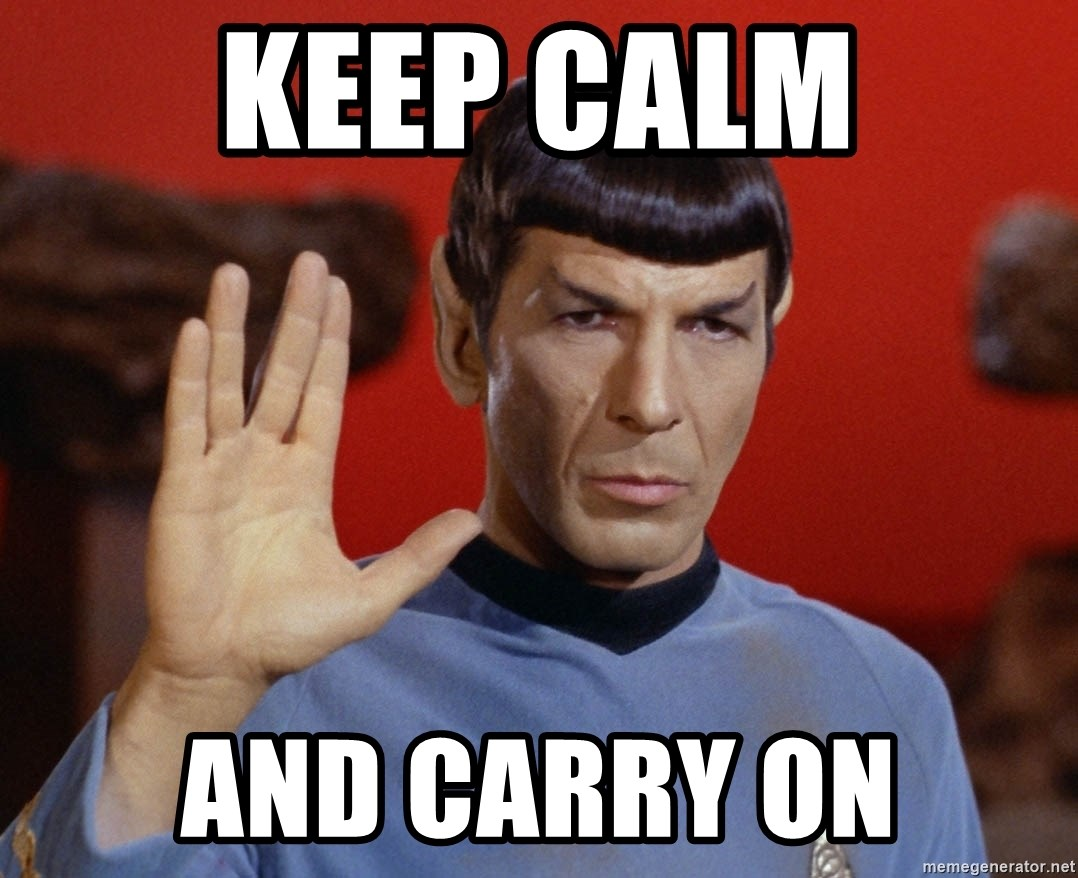

<a id="section-two"></a>
# 2) KFold
A second most common approach to validation is `KFold`: [Source](https://scikit-learn.org/stable/modules/cross_validation.html)

The issues mentioned for random split are valid for KFold as well:
- test data occurs before training data
- gaps in the training series (windows 2–4)
[Source](https://towardsdatascience.com/dont-use-k-fold-validation-for-time-series-forecasting-30b724aaea64)

However, [Bergmeir et al](https://robjhyndman.com/publications/cv-time-series/) make the case that it does work for autoregressions, i.e. series where the predictors are lagged values of the response variable. Since the features were anonymised, we cannot decide a priori whether this is the right approach. Instead, we must find out empirically:

In [91]:
%%time
from sklearn.model_selection import KFold

kf = KFold(
    n_splits=Config.nfolds, 
    shuffle=True, 
    random_state=Config.seed
)

res_vec = np.zeros((Config.nfolds, 1))

prv = np.zeros((xtest.shape[0], Config.nfolds))

for (ii, (id0, id1)) in enumerate(kf.split(xtrain)):
    print(f"fold: {str(ii)}")
    x0, x1 = xtrain.loc[id0], xtrain.loc[id1]
    y0, y1 = ytrain.loc[id0], ytrain.loc[id1]
    
    model = lgb.LGBMRegressor(**lgb_parameters)

    model.fit(
        x0, 
        y0, 
        eval_metric='rmse', 
        eval_set=[(x0, y0), (x1, y1)],
        callbacks=[wandb_callback]
    )
    
    val_preds = model.predict(x1)
    prv[:, ii] += model.predict(xtest) / Config.nfolds
    
    # validation score    
    score = np.round(p(val_preds, y1)[0], 4)
    res_vec[ii] = score
    print(f"validation score: {str(score)}")

    # actual test performance
    score = np.round(p(test_preds, ytest)[0], 4)
    print(f"test score: {str(score)}")
    
    del model, x0, x1, y0, y1

fold: 0


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2197623, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (628.74 MB) transferred to GPU in 0.161943 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.022344
validation score: 0.1894
test score: 0.1291
fold: 1


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2197623, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (628.74 MB) transferred to GPU in 0.170609 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.022075
validation score: 0.1897
test score: 0.1291
fold: 2


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2197623, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (628.74 MB) transferred to GPU in 0.161588 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.022133
validation score: 0.1917
test score: 0.1291
fold: 3


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2197623, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (628.74 MB) transferred to GPU in 0.167730 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.022417
validation score: 0.189
test score: 0.1291
fold: 4


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2197624, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (628.75 MB) transferred to GPU in 0.160894 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.022228
validation score: 0.189
test score: 0.1291
CPU times: user 13min 33s, sys: 14.1 s, total: 13min 47s
Wall time: 1min 15s


In [92]:
%%time
# average score
avg_score = np.round(np.mean(res_vec), 4)
print(f"Kfolds average score across folds: {str(avg_score)}")

# test score
score = np.round(p(ytest, prv.mean(axis=1))[0], 4)
print(f"Kfolds full test score: {str(score)}")

Kfolds average score across folds: 0.1898
Kfolds full test score: 0.1351
CPU times: user 111 ms, sys: 215 ms, total: 326 ms
Wall time: 11.2 ms


The large gap between validation and test scores shows us that there is still substantial overfit occurring, indicating that **whatever the features are, they are not (a proxy for) lagged values of the target variable**. 

What if we tried to do something more time-series oriented, that took the temporal dependency explicitly into account? There are two changes that come to mind:
- respect the chronological order of the data $\rightarrow$ the training set should occur before the validation set, which should occur before the test set
- the test set should move over time

<a id="section-three"></a>
# 3) Time Series Split (Walk forward validation)

It should be obvious that this split problem is common to time series. So, unsurprisingly, SK-Learn has a split method specifically name `TimeSeriesSplit`, with this situation in mind. The scikit-learn implementation of a time series split (a.k.a walk forward validation [Source](https://audhiaprilliant.medium.com/walk-forward-optimization-cross-validation-technique-for-time-series-data-61739f58f2c0)) is a variation of `KFold`: 
- in the $k$th split, it returns first $k$ folds as train set and the $(k+1)$th fold as test set
- successive training sets can be supersets of those that came before them or have a fixed size $\rightarrow$ controlled by *max_train_size* argument. 
- useful in time-sensitive contexts like trading $\rightarrow$ robustness of a strategy, concept drift
- backtesting is based around wfv - with / without refitting the model

Let's test with a progressively increasing train set:

In [93]:
%%time

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=Config.nfolds, max_train_size=None)

res_vec = np.zeros((Config.nfolds, 1))

CPU times: user 826 µs, sys: 36 µs, total: 862 µs
Wall time: 34.1 µs


In [94]:
%%time

for (ii, (id0, id1)) in enumerate(tscv.split(xtrain)):
    x0, x1 = xtrain.loc[id0], xtrain.loc[id1]
    y0, y1 = ytrain.loc[id0], ytrain.loc[id1]
    
    model = lgb.LGBMRegressor(**lgb_parameters)

    model.fit(
        x0, 
        y0, 
        eval_metric='rmse', 
        eval_set=[(x0, y0), (x1, y1)],
        callbacks=[wandb_callback]
    )
    
    val_preds = model.predict(x1)
    prv[:, ii] += model.predict(xtest) / Config.nfolds
    
    # validation score    
    score = np.round(p(val_preds, y1)[0], 4)
    res_vec[ii] = score
    print(f"validation score: {str(score)}")

    # actual test performance
    test_preds = model.predict(xtest)
    score = np.round(p(test_preds, ytest)[0], 4)
    print(f"test score: {str(score)}")
    del model, x0, x1, y0, y1
    
gc.collect()

/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 457839, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 299 dense feature groups (130.99 MB) transferred to GPU in 0.024767 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.023452
validation score: 0.1272
test score: 0.0791


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 915677, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 299 dense feature groups (261.98 MB) transferred to GPU in 0.051036 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.035685
validation score: 0.1542
test score: 0.0833


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1373515, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 299 dense feature groups (392.97 MB) transferred to GPU in 0.091487 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.031654
validation score: 0.1117
test score: 0.0914


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1831353, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 299 dense feature groups (523.95 MB) transferred to GPU in 0.132875 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.028896
validation score: 0.113
test score: 0.1023


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2289191, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (654.94 MB) transferred to GPU in 0.166497 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.025100
validation score: 0.13
test score: 0.1175
CPU times: user 9min 44s, sys: 22.3 s, total: 10min 6s
Wall time: 55.6 s


183

In [95]:
%%time
# average score
avg_score = np.round(np.mean(res_vec), 4)
print(f"TSS average score across folds: {str(avg_score)}")

# test score
score = np.round(p(ytest, prv.mean(axis=1))[0], 4)
print(f"TSS full test score: {str(score)}")

TSS average score across folds: 0.1272
TSS full test score: 0.124
CPU times: user 33.4 ms, sys: 4.93 ms, total: 38.4 ms
Wall time: 9.36 ms


What if we limit the size of the training set? [Source](https://audhiaprilliant.medium.com/walk-forward-optimization-cross-validation-technique-for-time-series-data-61739f58f2c0)

In [96]:
%%time

tscv = TimeSeriesSplit(
    n_splits=Config.nfolds, 
    max_train_size=2 * xtest.shape[0]
)

res_vec = np.zeros((Config.nfolds, 1))

for (ii, (id0, id1)) in enumerate(tscv.split(xtrain)):
    x0, x1 = xtrain.loc[id0], xtrain.loc[id1]
    y0, y1 = ytrain.loc[id0], ytrain.loc[id1]
    
    model = lgb.LGBMRegressor(**lgb_parameters)

    model.fit(
        x0, 
        y0, 
        eval_metric='rmse', 
        eval_set=[(x0, y0), (x1, y1)],
        callbacks=[wandb_callback]
    )
    
    val_preds = model.predict(x1)
    prv[:, ii] += model.predict(xtest) / Config.nfolds
    
    # validation score    
    score = np.round(p(val_preds, y1)[0], 4)
    res_vec[ii] = score
    print(f"validation score: {str(score)}")

    # actual test performance
    test_preds = model.predict(xtest)
    score = np.round(p(test_preds, ytest)[0], 4)
    print(f"test score: {str(score)}")

    del model, x0, x1, y0, y1

/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 457839, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 299 dense feature groups (130.99 MB) transferred to GPU in 0.024563 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.023452
validation score: 0.1272
test score: 0.0791


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 788762, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 299 dense feature groups (225.67 MB) transferred to GPU in 0.040080 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.037684
validation score: 0.1512
test score: 0.0811


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 788762, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 299 dense feature groups (225.67 MB) transferred to GPU in 0.040440 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.037014
validation score: 0.1041
test score: 0.0855


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 788762, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (225.67 MB) transferred to GPU in 0.045396 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.018263
validation score: 0.1124
test score: 0.0853


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 788762, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (225.67 MB) transferred to GPU in 0.039851 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.014316
validation score: 0.1182
test score: 0.1176
CPU times: user 6min 37s, sys: 18.6 s, total: 6min 56s
Wall time: 39.8 s


In [97]:
%%time
# average score
avg_score = np.round(np.mean(res_vec), 4)
print(f"average score across folds: {str(avg_score)}")

# test score
score = np.round(p(ytest, prv.mean(axis=1))[0], 4)
print(f"full test score: {str(score)}")

average score across folds: 0.1226
full test score: 0.1207
CPU times: user 159 ms, sys: 379 ms, total: 538 ms
Wall time: 18.1 ms


WFV pros: 
- clear historical interpretation 
- history is a [filtration](https://en.wikipedia.org/wiki/Filtration_(probability_theory))

WFV cons:
- one single scenario is tested, which is easily overfit (coming later)
- initial decisions based on smaller portion of the total sample 
- future performance / concept drift $\rightarrow$ not wfv-specific

Both fixed and increasing train set do better than the predecessors, but as usual with these things it helps to look at the details 
The very idea of time-based split is that we avoid peeking forward in time 

In [98]:
%%time
for train_idx, test_idx in TimeSeriesSplit().split(xtrain):
    id1 = time_train.loc[train_idx].unique()
    id2 = time_train.loc[test_idx].unique()
    print(np.intersect1d(id1, id2))

[203]
[434]
[629]
[799]
[954]
CPU times: user 341 ms, sys: 371 ms, total: 711 ms
Wall time: 205 ms


- First split: day 44 is present in both training and test $\implies$ we are training on half of the trades of a certain day, just to validate their performance on the other half of the trades of that day
- so we have a cleaner split, but not as clean as we'd like. 
- We can do better!

# Recap so far:
- Niave CV: overfitting evident from large gap between validation and test scores
- KFold: not much better.
- `TimeSeriesSplit` is another way round

<a id="section-four"></a>
# 4) Group Time Series

- The `GroupKFold` iterator does respect groupings: no group will ever be part of two folds **BUT** it messes up the temporal order, in the same way as Naive CV and KFold.

- What we need is a a crossover between `GroupKFold` and `TimeSeriesSplit` 
- enter `GroupTimesSeriesSplit`. [**Gaurav Chawla**](https://www.kaggle.com/gc2713)
([git](https://github.com/getgaurav2/), [LI](https://www.linkedin.com/in/gauravchawla-columbia)) has created and shared just that with `GroupTimeSeriesSplit` - please do make check out his work!

The notebook we borrow the code from was written by [J.J. Smit](https://www.kaggle.com/jorijnsmit):  https://www.kaggle.com/code/jorijnsmit/found-the-holy-grail-grouptimeseriessplit.

In [99]:
%%time
from sklearn.model_selection import GroupKFold

for train_idx, test_idx in GroupKFold().split(xtrain, groups = pd.DataFrame(time_train)['time_id']):
    id1 = time_train.loc[train_idx].unique()
    id2 = time_train.loc[test_idx].unique()
    
    print(id1[0: 10])
    print(id2[0: 10])
    print(np.intersect1d(id1, id2))

    print('---')

[ 0  1  2  3  4  6  7  8  9 10]
[ 5 11 13 14 22 30 34 37 40 41]
[]
---
[ 0  1  2  5  8 10 11 12 13 14]
[ 3  4  6  7  9 15 17 24 39 49]
[]
---
[ 0  2  3  4  5  6  7  8  9 11]
[ 1 10 12 19 21 25 29 33 35 36]
[]
---
[ 1  3  4  5  6  7  8  9 10 11]
[ 0  2 16 26 28 31 32 42 48 61]
[]
---
[ 0  1  2  3  4  5  6  7  9 10]
[ 8 18 20 23 27 43 45 55 58 63]
[]
---
CPU times: user 393 ms, sys: 7.95 ms, total: 401 ms
Wall time: 398 ms


In [100]:
# Taken from notebook
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """
    Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """
        Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(("Cannot have number of folds={0} greater than the number of groups={1}").format(n_folds, n_groups))
        
        group_test_size = n_groups // n_folds
        group_test_starts = range(
            n_groups - n_splits * group_test_size,
            n_groups, 
            group_test_size
        )
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(np.concatenate((train_array, train_array_tmp)), axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end - self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(np.concatenate((test_array, test_array_tmp)), axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]

Let's see how it performs:

In [101]:
# sanity check
for train_idx, test_idx in GroupTimeSeriesSplit().split(xtrain, groups = pd.DataFrame(time_train)['time_id']):
    id1 = time_train.loc[train_idx].unique()
    id2 = time_train.loc[test_idx].unique()
    
    print(id1[0: 25])
    print(id2[0: 25])
    print(np.intersect1d(id1, id2))    
    
    print('---')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206]
[]
---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[365 366 367 373 374 375 376 377 378 379 380 381 383 384 385 386 387 388
 389 390 391 392 393 394 395]
[]
---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572
 573 574 575 576 577 578 579]
[]
---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[737 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754
 755 756 757 758 759 760 761]
[]
---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[919 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935 936
 937 938 939 940 941 942 943]
[]
---


# comments / Observations

In [102]:
res_vec = np.zeros((Config.nfolds, 1))

for (ii, (id0, id1)) in enumerate(GroupTimeSeriesSplit().split(xtrain, groups = pd.DataFrame(time_train)['time_id'])):
    x0, x1 = xtrain.loc[id0], xtrain.loc[id1]
    y0, y1 = ytrain.loc[id0], ytrain.loc[id1]
    
    model = lgb.LGBMRegressor(**lgb_parameters)

    model.fit(
        x0, 
        y0, 
        eval_metric='rmse', 
        eval_set=[(x0, y0), (x1, y1)],
        callbacks=[wandb_callback]
    )
    
    val_preds = model.predict(x1)
    prv[:, ii] += model.predict(xtest) / Config.nfolds
    
    # validation score    
    score = np.round(p(val_preds, y1)[0],4)
    res_vec[ii] = score
    print(f"validation score: {str(score)}")

    # actual test performance
    test_preds = model.predict(xtest)
    score = np.round(p(test_preds, ytest)[0], 4)
    print(f"test score: {str(score)}")

    del model, x0, x1, y0, y1

/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 410506, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 299 dense feature groups (117.45 MB) transferred to GPU in 0.020269 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.023303
validation score: 0.1296
test score: 0.0772


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 803959, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 299 dense feature groups (230.01 MB) transferred to GPU in 0.040126 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.035888
validation score: 0.1463
test score: 0.0883


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1189677, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 299 dense feature groups (340.37 MB) transferred to GPU in 0.076225 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.033731
validation score: 0.1221
test score: 0.0897


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1656468, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 299 dense feature groups (473.92 MB) transferred to GPU in 0.114755 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.030045
validation score: 0.1122
test score: 0.0982


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2180292, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (623.79 MB) transferred to GPU in 0.166286 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.025824
validation score: 0.1239
test score: 0.1154


In [103]:
%%time
# average score
avg_score = np.round(np.mean(res_vec), 4)
print(f"GroupedTimeSeries average score across folds: {str(avg_score)}")

# test score
score = np.round(p(ytest, prv.mean(axis=1))[0], 4)
print(f"GroupedTimeSeries full test score: {str(score)}")

GroupedTimeSeries average score across folds: 0.1268
GroupedTimeSeries full test score: 0.1182
CPU times: user 38.3 ms, sys: 1.22 ms, total: 39.5 ms
Wall time: 9.13 ms


The validation and test scores are now a lot closer, and the RMSE for both is lower. Clearly much better. In terms of non-financial applications, the above is probably fit for purpose most of the time. 

In finance and trading though, the game is all about aggregation of marginal gains. And we can still do better!

<a id="section-five"></a>
# 5) Purged Group Time Series

As we have seen above, moving to Group Time Series split improves the situation. If we focus on the specific domain of this competition (finance), we can go a step further and make the validation scheme a little closer to the real situation - by exploring the nature of event times in finance:

* a labelled data point in a financial time series has a trade time and an event time.

* event time = when in the future the mark-to-market value of an asset reached a certain level such as a stop loss or a take profit price. 

* this means that labels become path-dependent, and care needs to be taken so that when computing labels we don't peek into the out-of-sample fold.

Excellent example from https://blog.quantinsti.com/cross-validation-embargo-purging-combinatorial/:

For a concrete example, say we are trying to build an ML model to predict whether IBM prices would move up or down in the next 5 business days by at least 50 basis points (bps) based on various data sources. The size of these movements are estimated based on recent levels of realised volatility for IBM shares. A common labelling scheme would be: +1 if the share price moves more than 50 bps, 0 if the share price moves by less than 50 bps in absolute value, and -1 if the share price moves down by more than 50 bps. Next, let's assume that our typical trading horizon is 1 week. You would enter a position today, and liquidate it one week later. Most people in practice however would have a stop loss or take profit level for a trade so that they can exit a trade earlier if either of those levels are reached. The point is that to mark-to-market your trade, you'd need to observe the price path during the next 5 days, or for the next 5 ticks (you could exit before).

TL;DR **In the labelling process, we have to take care to remove data for which the event times overlap with the trade times in the test fold. This process is called purging.**



We build on the code from https://www.kaggle.com/code/marketneutral/purged-time-series-cv-xgboost-optuna:

- `GroupTimeSeriesSplit` is the basis 
- we add a `gap` between each train and validation split: the group aspect keeps whole days together, but anonymized features have some kind of lag or window calculations in them (results from our `KFold` section notwithstanding). By introducing a gap, we mitigate the risk that we leak information from train into validation
- we can specify the size of the train and validation splits in terms of number of days.
- the sizes of the train, gap, and valid sets respect the different number of samples per day. 
- you can split the data on number of days in the validation set, number of days gap between, and number of days in the train set.

You can see in the "group" bars that the days are different lengths.
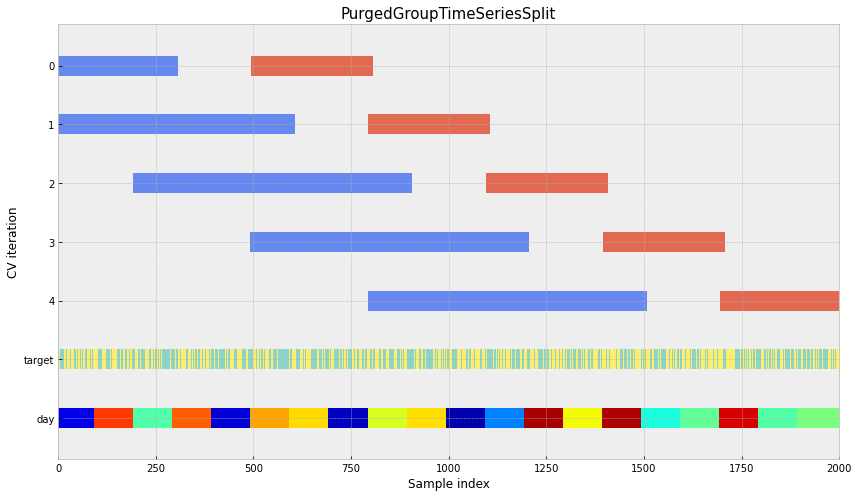

In [104]:
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """
    Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(("Cannot have number of folds={0} greater than the number of groups={1}").format(n_folds, n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(
            n_groups - n_splits * group_test_size,
            n_groups, 
            group_test_size
        )
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(np.concatenate((train_array, train_array_tmp)), axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(np.concatenate((test_array, test_array_tmp)), axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [105]:
cv = PurgedGroupTimeSeriesSplit(
    n_splits=5,
    max_train_group_size=15, 
    group_gap=5, 
    max_test_group_size=5
)

In [106]:
res_vec = np.zeros((Config.nfolds, 1))

for (ii, (id0, id1)) in enumerate(cv.split(xtrain, groups = pd.DataFrame(time_train)['time_id'])):
    x0, x1 = xtrain.loc[id0], xtrain.loc[id1]
    y0, y1 = ytrain.loc[id0], ytrain.loc[id1]
    
    model = lgb.LGBMRegressor(**lgb_parameters)

    model.fit(
        x0, 
        y0, 
        eval_metric='rmse', 
        eval_set=[(x0, y0), (x1, y1)],
        callbacks=[wandb_callback]
    )
    
    val_preds = model.predict(x1)
    prv[:, ii] += model.predict(xtest) / Config.nfolds
    
    # validation score    
    score = np.round(p(val_preds, y1)[0], 4)
    res_vec[ii] = score
    print(f"validation score: {str(score)}")

    # actual test performance
    test_preds = model.predict(xtest)
    score = np.round(p(test_preds, ytest)[0], 4)
    print(f"test score: {str(score)}")

    del model, x0, x1, y0, y1

/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 47611, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (13.62 MB) transferred to GPU in 0.004798 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.020561
validation score: 0.1121
test score: 0.0713


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 47500, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (13.59 MB) transferred to GPU in 0.004732 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.010528
validation score: 0.0509
test score: 0.0747


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 47479, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (13.58 MB) transferred to GPU in 0.004877 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.006251
validation score: 0.0506
test score: 0.0678


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 47445, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (13.57 MB) transferred to GPU in 0.005093 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.002360
validation score: -0.0381
test score: 0.0841


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 46125, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (13.20 MB) transferred to GPU in 0.004763 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.021580
validation score: 0.0615
test score: 0.0704


In [107]:
%%time
# average score
avg_score = np.round(np.mean(res_vec), 4)
print(f"PurgedGroupTimeSeries average score across folds: {str(avg_score)}")

# test score
score = np.round(p(ytest, prv.mean(axis=1))[0], 4)
print(f"PurgedGroupTimeSeries full test score: {str(score)}")

PurgedGroupTimeSeries average score across folds: 0.0474
PurgedGroupTimeSeries full test score: 0.1253
CPU times: user 35.3 ms, sys: 373 ms, total: 409 ms
Wall time: 14.2 ms


## Conclusions:
- We can see a nice reduction in RMSE for both validation and test scores. 
- This means an improvement in performance. 
- We also see a relatively small difference between RMSE for validation and test, so we're still see less overfitting than our early experiments.

In this case, a purge has given us an uplift!

<a id="section-six"></a>

# 6) Combinatorial purged group KFold

While the approaches demonstrated above differ in several aspects, they share one characteristic: each of them only tests a single path $\rightarrow$ no counterfactuals possible; 
a single backtest path is simulated $\rightarrow$ one and only one forecast is generated per observation. 

Alternative approach: some combinatorial tricks to **generate multiple backtest paths**.


How does it work in practice https://towardsai.net/p/l/the-combinatorial-purged-cross-validation-method4

CPCV provides the exact number of combinations of training/testing sets required to construct a set of backtesting paths while purging training observations that contain leaked information, given a set of backtest paths targeted by the researcher.

First, we have our data, say 1000 data points. Imagine we want to split those 1000 datapoints into 6 groups. Of these 6 groups, we want 2 test groups (figure below).
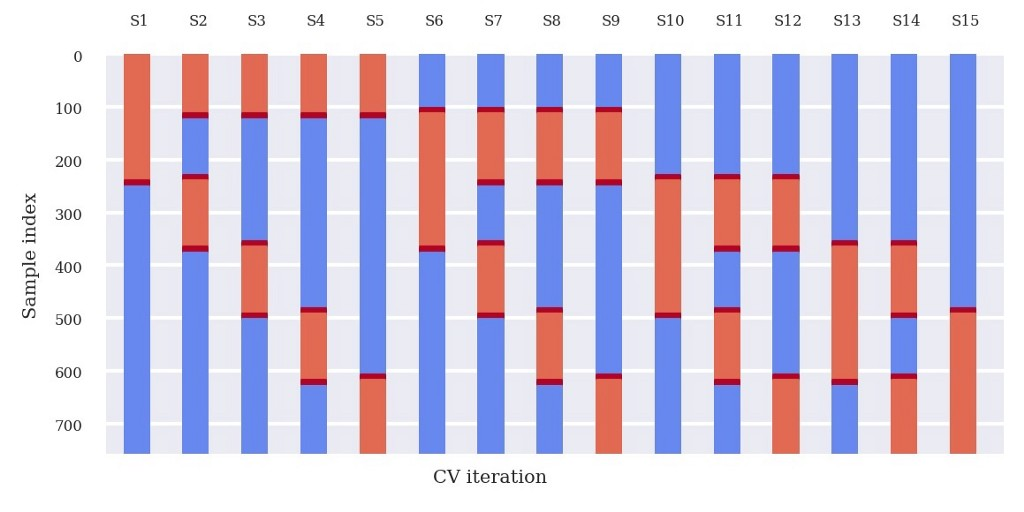

How many data splits are possible? 

\begin{equation}
\binom{6}{6-2}= 15
\end{equation}

Every split involves k=2 tested groups, which means that the total amount of testing groups is k * N_splits, which is 30. Moreover, since we have computed all possible combinations, these tested groups are uniformly distributed across all $N$. Therefore, there is a total number of paths 30 / 6 = 5 paths.

Figure 1 indicates the groups that make up the testing set with an x and leaves the groups that make up the training set unmarked for each split. This train/test split technique allows us to compute 5 backtest pathways because each group is a member of $\phi$[6, 2] = 5 testing sets.

For a detailed description We take the implementation from [here](https://www.kaggle.com/code/gogo827jz/combinatorial-purged-group-k-fold)

In [108]:
import numpy as np
from scipy.special import comb
from itertools import combinations

class CombinatorialPurgedGroupKFold():
    def __init__(self, n_splits=6, n_test_splits=2, purge=1, pctEmbargo=0.01, **kwargs):
        self.n_splits = n_splits
        self.n_test_splits = n_test_splits
        self.purge = purge
        self.pctEmbargo = pctEmbargo
        
    def split(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
            
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_groups = len(unique_groups)
        group_dict = {}
        for idx in range(len(X)):
            if groups[idx] in group_dict:
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
                
        n_folds = comb(self.n_splits, self.n_test_splits, exact=True)
        if n_folds > n_groups:
            raise ValueError(("Cannot have number of folds={0} greater than the number of groups={1}").format(n_folds, n_groups))
            
        mbrg = int(n_groups * self.pctEmbargo)
        if mbrg < 0:
            raise ValueError("The number of 'embargoed' groups should not be negative")
        
        split_dict = {}
        group_test_size = n_groups // self.n_splits
        for split in range(self.n_splits):
            if split == self.n_splits - 1:
                split_dict[split] = unique_groups[int(split * group_test_size):].tolist()
            else:
                split_dict[split] = unique_groups[int(split * group_test_size):int((split + 1) * group_test_size)].tolist()
        
        for test_splits in combinations(range(self.n_splits), self.n_test_splits):
            test_groups = []
            banned_groups = []
            for split in test_splits:
                test_groups += split_dict[split]
                banned_groups += unique_groups[split_dict[split][0] - self.purge:split_dict[split][0]].tolist()
                banned_groups += unique_groups[split_dict[split][-1] + 1:split_dict[split][-1] + self.purge + mbrg + 1].tolist()
            train_groups = [i for i in unique_groups if (i not in banned_groups) and (i not in test_groups)]

            train_idx = []
            test_idx = []
            for train_group in train_groups:
                train_idx += group_dict[train_group]
            for test_group in test_groups:
                test_idx += group_dict[test_group]
            yield train_idx, test_idx

What really happens? Let's test on a toy dataset:

In [109]:
n_splits = 6
n_test_splits = 1
elements = list(range(10 * (n_splits + n_test_splits)))
groups = [element // n_splits for element in elements]
data = pd.DataFrame({"group": groups, "element": elements})
kfold = CombinatorialPurgedGroupKFold(n_splits, n_test_splits)
for index, (train_indices, test_indices) in enumerate(kfold.split(data, groups=data["group"])):
    print("=" * 100)
    print(f"Fold {index}")
    print("=" * 100)
    print("Train indices:", train_indices, "Length:", len(train_indices))
    print("Test Indices:", test_indices, "Length:", len(test_indices))

Fold 0
Train indices: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69] Length: 52
Test Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] Length: 12
Fold 1
Train indices: [0, 1, 2, 3, 4, 5, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69] Length: 46
Test Indices: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] Length: 12
Fold 2
Train indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69] Length: 46
Test Indices: [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] Length: 12
Fold 3
Train indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2

Moving on to complete data:

In [110]:
n_splits = 5
n_test_splits = 1
kfold = CombinatorialPurgedGroupKFold(n_splits, n_test_splits)

for (ii, (id0, id1)) in enumerate(kfold.split(xtrain, groups = pd.DataFrame(time_train)['time_id'])):
    x0, x1 = xtrain.loc[id0], xtrain.loc[id1]
    y0, y1 = ytrain.loc[id0], ytrain.loc[id1]
    
    model = lgb.LGBMRegressor(**lgb_parameters)

    model.fit(
        x0, 
        y0, 
        eval_metric='rmse', 
        eval_set=[(x0, y0), (x1, y1)]
    )
    
    val_preds = model.predict(x1)
    prv[:, ii] += model.predict(xtest) / Config.nfolds
    
    # validation score    
    score = np.round(p(val_preds, y1)[0], 4)
    res_vec[ii] = score
    print(f"validation score: {str(score)}")

    # actual test performance
    test_preds = model.predict(xtest)
    score = np.round(p(test_preds, ytest)[0], 4)
    print(f"test score: {str(score)}")

    del model, x0, x1, y0, y1

/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2231403, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (638.41 MB) transferred to GPU in 0.172356 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.021814
validation score: 0.1363
test score: 0.1342


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2274373, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (650.70 MB) transferred to GPU in 0.170530 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.016464
validation score: 0.1533
test score: 0.1339


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2195280, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (628.07 MB) transferred to GPU in 0.165203 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.022170
validation score: 0.1553
test score: 0.1319


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2108582, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (603.27 MB) transferred to GPU in 0.156839 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.024465
validation score: 0.1195
test score: 0.1257


/home/noone/Documents/GitHub/ubiquant/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2065452, number of used features: 300
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 299 dense feature groups (590.93 MB) transferred to GPU in 0.151779 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.026121
validation score: 0.1229
test score: 0.116


In [111]:
%%time
# average score
avg_score = np.round(np.mean(res_vec), 4)
print(f"average score across folds: {str(avg_score)}")

# test score
score = np.round(p(ytest, prv.mean(axis=1))[0], 4)
print(f"full test score: {str(score)}")

average score across folds: 0.1375
full test score: 0.128
CPU times: user 69.7 ms, sys: 341 ms, total: 411 ms
Wall time: 14.2 ms


In [112]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▂▇▄▂▇▄▁▆▃█▅▃▇▆▄▁▆▃█▅▂▇▅▂▇▄▃█▅▂▇▄▂▆▄▁▆▃█▇
rmse_training,█▇██▇██▇█▇▇▇▇▇▇█▇█▇▇▇▆▇█▇▇▇▇▇█▇▇▆▁▄▇▂▄▁▁
rmse_valid_1,▅▅▅▆▅▅▆▅▅▅▃▅▅▆█▆▅▃▄▅▆▆█▅▅▅▃▃▆▇▇▆▅▆▅▁▃▂▄▂
epoch,149
rmse_training,0.7239
rmse_valid_1,0.88525


# Comparison of results

| Cross Validation method          | Validation RMSE | Test RMSE |
|----------------------------------|-----------------|-----------|
| Naive                            | 0.1886          | 0.1291    |
| KFold                            | 0.1898          | 0.1351    |
| TimeSeriesSplit                  | 0.13            | 0.1175    |
| GroupedTimeSeriesSplit           | 0.1182          | 0.1176    |
| PurgedGroupTimeSeriesKFold       | 0.0614          | 0.0704    |
| Combinatorial Purged Group KFold | ?               | ?         |


## Conclusions
This review of time series cross validation techniques should show us that 
- the temporal component of time series makes cross validation and improving model performance particularly challenging compared with other domains.
- experimenting with different cross validation approaches can help reduce overfitting and reduce RMSE (or other metric), while holding all other model components unchanged.

## Recommended further reading: 
- [Forecasting Evaluation for Data Scientists: Common pitfalls and best practices](https://www.arxiv-vanity.com/papers/2203.10716/)

In [113]:
# todo: 
#  average validation and test scores for each model,
#  store validation and test scores for each approach in df, 
#  plot results of each approach, 
#  logging, 
#  wandb
#  improve the words, images, structure and narrative,